In [2]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-01 14:50:18
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-01 14:52:17
FilePath: /Gtext/xiu/fixword_ex.ipynb
Description: 

'''

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

##################### Could be changed part ##########################
sparse_folder = 'results_primary_news_sparse_multiyears/'
index_folder = 'results_primary_news_index_multiyears/'

sparse_file = '2005_2020_sparse/2005_2014_sparse_threecol.csv'
index_file = '2005_2020_index_news/2005_2014_index_news.csv'
word_file = '2005_2014_stemmed_word_count.csv'

sparse_file0 = '2005_2020_sparse/2015_2019_sparse_threecol.csv'
index_file0 = '2005_2020_index_news/2015_2019_index_news.csv'


sparse_file1 = '2005_2020_sparse/2020_2020_sparse_threecol.csv'
index_file1 = '2005_2020_index_news/2020_2020_index_news.csv'

######################################################################

######################## Could be put in the function module py file ########################
# Define a function to transform data from three columns to sparse matrix
def trans_data(sparse_data, news_data, word_data):
    '''
    :param sparse_data: the three column saved words DataFrame includes 'Row', 'Column', 'Value'
    :param news_data: news DataFrame includes 'Row_ID', 'permno', 'returnday_1', 'threedayreturn', 'title'
    :param word_data: words DataFrame includes 'WordIndex', 'final_word', 'TotalWordNum', 'TotalBodyNum'

    :return W_array: sparse matrix of word counts, n*k --> n: # of news, k: # of words
    :return r_array: return vector, length == # of news
    :return stkcd_array: permno vector, length == # of news
    :return date_array: date vector, length == # of news
    '''
    if 'return' in news_data.columns :
        r_array = np.array(news_data['return'])
        date_array = np.array(news_data['returnday'])
    else:  
        r_array = np.array(news_data['threedayreturn'])
        date_array = np.array(news_data['returnday_1'])
    stkcd_array = np.array(news_data['permno'])
    
    
    # Transform three columns to sparse matrix W
    newrowarray = np.array(sparse_data['Row'])
    newcolarray = np.array(sparse_data['Column'])
    newvaluearray = np.array(sparse_data['Value'])

    W_array = sparse.csr_matrix((newvaluearray, (newrowarray, newcolarray)), shape = (newrowarray[-1]+1, word_data.shape[0])).toarray()

    return W_array, r_array, stkcd_array, date_array

#############################################################################################

# Load in data set
df_sparse = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + sparse_folder + sparse_file)
df_newsindex = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + index_folder + index_file)
df_words = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + word_file)
df_words = df_words.dropna().reset_index(drop = True).reset_index()

df_sparse0= pd.read_csv('/home/yuanzhi/Text_individual/codes/' + sparse_folder + sparse_file0)
df_newsindex0 = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + index_folder + index_file0)


df_sparse1= pd.read_csv('/home/yuanzhi/Text_individual/codes/' + sparse_folder + sparse_file1)
df_newsindex1 = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + index_folder + index_file1)

W_train, r_train, stkcd, datearray = trans_data(df_sparse, df_newsindex, df_words)
W_vali, r_vali, stkcd0, datearray0 = trans_data(df_sparse0, df_newsindex0, df_words)
W_test, r_test, stkcd1, datearray1 = trans_data(df_sparse1, df_newsindex1, df_words)



In [3]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-01 14:50:18
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-04 09:13:18
FilePath: /Gtext/xiu/fixword_ex.ipynb
Description: 

'''
import heapq
from collections import Counter

def SESTM1(W_train, r_train, alpha_posnum, alpha_negnum, kappa):
    n, S = W_train.shape

    ###################Screening Part##############
    #####each year have appearance_word list#####
    # appearance_word = df_words.TotalBodyNum
    appearance_word = sum(W_train>0)
    print(np.quantile(appearance_word,kappa))

    # appearance_word = df_words.TotalBodyNum
    yearcount = dict(Counter([datearray[i][:4] for i in range(n)]))
    start = 0
    freq_index = []
    for key, value in yearcount.items():
        print(key, value)

        appearance_word0 = sum(W_train[start:start + value]>0)
        # freq_index = list({np.where(appearance_word0 > np.quantile(appearance_word0, kappa))[0]}.union(freq_index))
        
        # print('print(np.quantile(appearance_word,kappa))',np.quantile(appearance_word0,kappa))
        freq_index =list(set(np.where(appearance_word0 >= np.quantile(appearance_word0,kappa))[0]).union(set(freq_index)))
        # print(len(appearance_word0),len(freq_index))
        start += value
            # print(len(freq_index))
    print(len(appearance_word),len(freq_index))
    print(len(freq_index))

    # print(np.quantile(appearance_word,kappa))
    # pi = sum(np.array([r_train[i] for i in freq_index])>0)/len(freq_index)
    pi = sum(r_train>0)/len(r_train)
    print('pi',pi)
    # pi=0.5
    WS_pos_index = []  #index of the positive sentiment word
    WS_neg_index = []  #index of the negative sentiment word
    fq_pos = {}
    fq_neg = {}

    for i in tqdm(freq_index):
        # calculte f* to screen
        i_index = np.nonzero(W_train[:,i])[0] # count of word i appearance in all article
        # print(i)
        # print(len(i_index))
        # # print(df_words.TotalBodyNum[i])
        # print(appearance_word[i])
        num_i_index = len(i_index)
        f_r = sum(r_train[i_index]>0) # count of word i in all articles and having r>0   
        # print(f_r)
        # print(f_r/quantile_word[i])
        if f_r/num_i_index  >= pi:
        # if f_r/appearance_word[i] >= pi:
            # fq_pos[i] = f_r/appearance_word[i]  
            fq_pos[i] = f_r/num_i_index   
            # if  fq_pos[i] ==1:
            #     print(i,appearance_word[i])
        else:
            # fq_neg[i] = f_r/appearance_word[i]
            fq_neg[i] = f_r/num_i_index    
            # if  fq_neg[i] ==0:
            #     print(i,appearance_word[i])
        # if i ==2588:
        #     print( 'hi',f_r/num_i_index,f_r,num_i_index)
        # if i ==1670:
        #     print( 'hi',f_r/num_i_index,f_r,num_i_index)
    # print("fq_pos",fq_pos)
    # print('print(fq_neg)  ',fq_neg)  
    WS_pos_index = heapq.nlargest(alpha_posnum, fq_pos, key=lambda x: fq_pos[x])
    # print(len(WS_pos_index)) 
    WS_neg_index = heapq.nsmallest(alpha_negnum, fq_neg, key=lambda x: fq_neg[x])
    
    print([fq_pos[i] for i in WS_pos_index])
    print([fq_neg[i] for i in WS_neg_index])
    ###################Screening Part##############
    return WS_pos_index, WS_neg_index, fq_pos , fq_neg

# WS_pos_index,WS_neg_index,fq_pos,fq_neg = SESTM1(W_train, r_train, 100, 100, 0.92)
# # WS_pos_index,WS_neg_index = SESTM1(W_train, r_train, alpha_posnum, alpha_negnum, kappa)
# # print(stkcd_array[WS_pos_index,:])
# print([(df_words.final_word[i]) for i in WS_pos_index])
# print([(df_words.final_word[i]) for i in WS_neg_index])

(-0.5, 399.5, 199.5, -0.5)

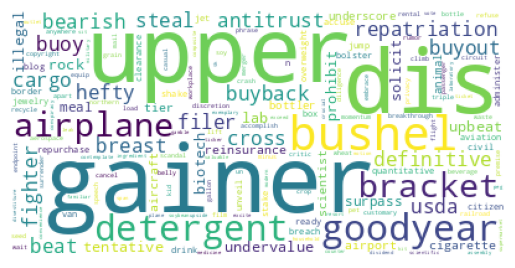

In [9]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

fq_pos = {df_words.final_word[k]: v for k, v in fq_pos.items()}
# print(fq_pos0)
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(frequencies=fq_pos))
plt.axis("off")


(-0.5, 399.5, 199.5, -0.5)

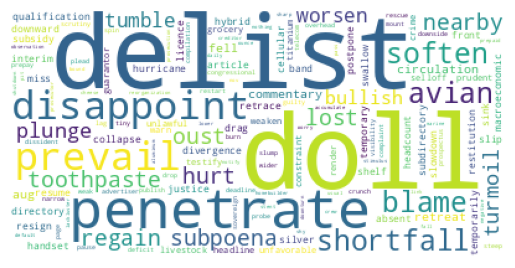

In [5]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
fq_neg = {df_words.final_word[k]: 1-v for k, v in fq_neg.items()}
        
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(frequencies=fq_neg))
plt.axis("off")

In [7]:

i_index = np.nonzero(W_train[:,2658])[0] # count of word i appearance in all article
num_i_index = len(i_index)
f_r = sum(r_train[i_index]>0) 
print(num_i_index,f_r)

323 194


In [4]:
import numpy as np
import pandas as pd
import heapq
from tqdm import tqdm
import time
from sklearn import preprocessing
# d_pos = [list(df_words.TotalBodyNum)[i] for i in index_neg_word_xiu]
# d_neg =  [list(df_words.TotalBodyNum)[i] for i in index_neg_word_xiu]

# WS_index = WS_pos_index + WS_neg_index

def SESTM2(W_train, r_train, WS_index):

    n, S = W_train.shape
    # n = len(W_train)
    # S = len(W_train[0])
    ############################Estimation Part ############################  
    r_order = np.argsort(r_train)+1
    phat = r_order/n # n
    
    s = np.zeros((n,S)) # construct a matrix only contains sentiment words
    s[:,WS_index] = W_train[:,WS_index]
    hhat = np.zeros((n,S)) 
    for i in range(n):
        if sum(s[i,:])!=0:
            hhat[i] = s[i,:]/sum(s[i,:])

    hhat = np.array(hhat) # specific sentiment word frequency in each article S x n
   
    Pmatrix = np.array([phat,1-phat])
    
    P_inverse = np.linalg.inv(Pmatrix @ Pmatrix.T) #2 x 2
    
    # estimated theta
    # Ohat = P_inverse @ Pmatrix @ hhat

    Ohat = hhat.T@ Pmatrix.T @P_inverse 
    
    Ohat[Ohat < 0] = 0
 
    Ohat = preprocessing.normalize(Ohat.T, norm='l1').T # S x 2
    return Ohat


from scipy.optimize import minimize_scalar
def sentiment_score(W_test, Ohat, WS_index,lam):
    '''
    Input:
        W_test: Out-of-Sample sparse matrix
        Ohat: thetahat obtained from function sestm
        lam: lambda value
    Return:
        p_new: predicted sentiment score
    '''
    #test sample size
    n,S = W_test.shape  
    p_new = []
    # score each article's sentiment
    for i in tqdm(range(n)):   
        
        if not sum(W_test[i,WS_index]):   # no sentiment word found
            p_new.append(0.5)
        else:
            def pmle_objectfunction(X):
                # maxmize the object function
           
                # objfun = -np.sum(np.log(X * Ohat[WS_index][0]+ (1-X) * Ohat[WS_index][1])* W_test[i][WS_index] /np.sum(W_test[i,WS_index])) - lam * np.log(X*(1-X))
                objfun = -sum(np.log(X * Ohat[j, 0]+ (1-X) * Ohat[j, 1])* W_test[i,j]  for j in WS_index)/sum(W_test[i,WS_index])- lam * np.log(X*(1-X))
                
                return objfun
            solution = minimize_scalar(pmle_objectfunction, bounds=(0.0000001,0.9999999), method='bounded')
        
            # append sentiment score
            p_new.append(solution.x)
         
            # optimal_p = fminbound(lambda x: pmle_objectfunction(x),0,1)
            # print(optimal_p)
    return p_new

# p = sentiment_score(W_test, Ohat, WS_index,lam=1)

In [ ]:
WS_pos_index,WS_neg_index,fq_pos,fq_neg= SESTM1(W_train, r_train, 25, 25, 0.86)
WS_index = WS_pos_index + WS_neg_index
del fq_neg
del fq_pos
Ohat = SESTM2(W_train, r_train, WS_index)
sentiment_score(W_vali, Ohat, WS_index,1)

In [5]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-04 22:49:01
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-08 16:41:05
FilePath: /Gtext/xiu/selectword_view2.ipynb
Description: 

'''
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools

# loss function of validation set

def Hyperparam(W_train, r_train, W_vali, r_vali, Lam, Alpha_posnum, Kappa):
    def L1_loss(p1, p2):
        return np.sum(np.abs(p1 - p2))
    L1 = 0
    for result in itertools.product(Alpha_posnum,Kappa):    
        print(result)
        # lam = result[0]
        alpha_posnum = result[0]
        alpha_negnum = alpha_posnum
        kappa = result[1]
        ################################################################################################
        
        WS_pos_index,WS_neg_index,fq_pos,fq_neg= SESTM1(W_train, r_train, alpha_posnum, alpha_negnum, kappa)
        WS_index = WS_pos_index + WS_neg_index
        del fq_neg
        del fq_pos
        # ohat = SESTM2(W_train, r_train, ws_index)
        Ohat = SESTM2(W_train, r_train, WS_index)
        for i in Lam:
            p = sentiment_score(W_vali, Ohat, WS_index, i)
            r_order = np.argsort(r_vali) + 1
            phat = r_order/len(r_vali) # n
            if  L1_loss(p, phat) > L1:
                L1 = L1_loss(p, phat)
                hyperparamerter = result    
                lam = i
                print(hyperparamerter,lam)
           
        
    return lam,hyperparamerter, WS_index

Lam = [1]
Alpha_posnum = [25, 50, 100]
Alpha_posnum = [25, 50]
Alpha_negnum = Alpha_posnum 
Kappa = [0.86,0.88,0.90,0.92,0.94]
lam, (alpha_posnum, kappa),WS_index = Hyperparam(W_train, r_train, W_vali, r_vali, Lam, Alpha_posnum, Kappa)

(25, 0.86)
547.0
2005 7799
2006 9856
2007 7924
2008 13471
2009 18451
2010 20887
2011 25028
2012 24819
2013 27750
2014 26351
23244 4426
4426
pi 0.5198644261144261


100%|██████████| 4426/4426 [01:01<00:00, 72.43it/s] 


[0.7619047619047619, 0.6594202898550725, 0.6421052631578947, 0.6405959031657356, 0.6363636363636364, 0.6341463414634146, 0.6308724832214765, 0.6306729264475743, 0.619781631342325, 0.6153846153846154, 0.6133333333333333, 0.6111111111111112, 0.6086956521739131, 0.6086956521739131, 0.6081081081081081, 0.608058608058608, 0.6079854809437386, 0.607773851590106, 0.6046511627906976, 0.6027874564459931, 0.6016949152542372, 0.6009389671361502, 0.6006191950464397, 0.6, 0.6]
[0.22727272727272727, 0.34146341463414637, 0.38, 0.38738738738738737, 0.3925233644859813, 0.3954802259887006, 0.4, 0.40336134453781514, 0.40714285714285714, 0.40860215053763443, 0.4108761329305136, 0.42424242424242425, 0.42893208785660186, 0.43010752688172044, 0.4312169312169312, 0.43137254901960786, 0.43157894736842106, 0.43243243243243246, 0.43386243386243384, 0.436046511627907, 0.4370860927152318, 0.4375, 0.43776824034334766, 0.4395973154362416, 0.4411764705882353]


100%|██████████| 108263/108263 [07:27<00:00, 241.80it/s]


(25, 0.86) 1
(25, 0.88)
767.0
2005 7799
2006 9856
2007 7924
2008 13471
2009 18451
2010 20887
2011 25028
2012 24819
2013 27750
2014 26351
23244 3786
3786
pi 0.5198644261144261


100%|██████████| 3786/3786 [00:50<00:00, 75.40it/s] 


[0.7619047619047619, 0.6421052631578947, 0.6405959031657356, 0.6306729264475743, 0.619781631342325, 0.6153846153846154, 0.6133333333333333, 0.6086956521739131, 0.6081081081081081, 0.6079854809437386, 0.6046511627906976, 0.6009389671361502, 0.6006191950464397, 0.6, 0.5990338164251208, 0.5989010989010989, 0.5976331360946746, 0.596401028277635, 0.5946745562130178, 0.5939849624060151, 0.59375, 0.58984375, 0.5879265091863517, 0.5858585858585859, 0.5849802371541502]
[0.38738738738738737, 0.3925233644859813, 0.40336134453781514, 0.40860215053763443, 0.4108761329305136, 0.42424242424242425, 0.42893208785660186, 0.43010752688172044, 0.4312169312169312, 0.43243243243243246, 0.436046511627907, 0.4370860927152318, 0.43776824034334766, 0.4395973154362416, 0.4423076923076923, 0.4429530201342282, 0.4431438127090301, 0.44656488549618323, 0.44666666666666666, 0.44787644787644787, 0.4479166666666667, 0.4509090909090909, 0.4510822510822511, 0.45138178096212894, 0.45161290322580644]


100%|██████████| 108263/108263 [06:12<00:00, 290.59it/s]


(25, 0.9)
1216.7000000000007
2005 7799
2006 9856
2007 7924
2008 13471
2009 18451
2010 20887
2011 25028
2012 24819
2013 27750
2014 26351
23244 3089
3089
pi 0.5198644261144261


100%|██████████| 3089/3089 [00:46<00:00, 66.95it/s]


[0.6306729264475743, 0.619781631342325, 0.6133333333333333, 0.6009389671361502, 0.6006191950464397, 0.6, 0.5990338164251208, 0.5989010989010989, 0.596401028277635, 0.59375, 0.5879265091863517, 0.5849802371541502, 0.582995951417004, 0.5813953488372093, 0.5813586097946287, 0.5813253012048193, 0.5806451612903226, 0.5783132530120482, 0.5766129032258065, 0.5732099758648431, 0.5714285714285714, 0.5711382113821138, 0.5708756652152879, 0.570873786407767, 0.570873786407767]
[0.3925233644859813, 0.40860215053763443, 0.4108761329305136, 0.42893208785660186, 0.4370860927152318, 0.43776824034334766, 0.4395973154362416, 0.4429530201342282, 0.4431438127090301, 0.44787644787644787, 0.4510822510822511, 0.45138178096212894, 0.452970297029703, 0.45430809399477806, 0.455325232308792, 0.45564516129032256, 0.4560506452398344, 0.4563719862227325, 0.45733788395904434, 0.45799457994579945, 0.4583333333333333, 0.45883940620782726, 0.45893719806763283, 0.4598603839441536, 0.4604715672676838]


100%|██████████| 108263/108263 [08:17<00:00, 217.75it/s]


(25, 0.9) 1
(25, 0.92)
2059.5600000000013
2005 7799
2006 9856
2007 7924
2008 13471
2009 18451
2010 20887
2011 25028
2012 24819
2013 27750
2014 26351
23244 2465
2465
pi 0.5198644261144261


100%|██████████| 2465/2465 [00:29<00:00, 83.04it/s] 


[0.619781631342325, 0.6009389671361502, 0.6006191950464397, 0.6, 0.596401028277635, 0.5879265091863517, 0.582995951417004, 0.5783132530120482, 0.5732099758648431, 0.5714285714285714, 0.5708756652152879, 0.5677480916030534, 0.5665961945031712, 0.5639269406392694, 0.5628356605800214, 0.5626740947075209, 0.5611736966203825, 0.5600328947368421, 0.5584642233856894, 0.5542521994134897, 0.5526090675791274, 0.5515933232169955, 0.5513245033112583, 0.5501369863013699, 0.5501081470800289]
[0.4108761329305136, 0.42893208785660186, 0.4431438127090301, 0.4510822510822511, 0.45138178096212894, 0.455325232308792, 0.45564516129032256, 0.4560506452398344, 0.4563719862227325, 0.45799457994579945, 0.45893719806763283, 0.4598603839441536, 0.4607734806629834, 0.4607734806629834, 0.4611973392461197, 0.4612794612794613, 0.46400545888775163, 0.4648496900222248, 0.4652249265315349, 0.46622369878183834, 0.467210077806595, 0.46826758147512865, 0.4702750665483585, 0.4712911687554649, 0.4724104549854792]


100%|██████████| 108263/108263 [29:14<00:00, 61.71it/s] 


(25, 0.92) 1
(25, 0.94)
3583.4199999999983
2005 7799
2006 9856
2007 7924
2008 13471
2009 18451
2010 20887
2011 25028
2012 24819
2013 27750
2014 26351
23244 1880
1880
pi 0.5198644261144261


100%|██████████| 1880/1880 [00:34<00:00, 54.39it/s]


[0.619781631342325, 0.6009389671361502, 0.596401028277635, 0.5879265091863517, 0.582995951417004, 0.5732099758648431, 0.5708756652152879, 0.5626740947075209, 0.5611736966203825, 0.5600328947368421, 0.5501369863013699, 0.550071530758226, 0.5500710227272727, 0.5492937445949841, 0.5485436893203883, 0.5483645878761448, 0.5473214285714286, 0.5473161650636054, 0.5470932852636322, 0.5469745222929936, 0.5469436001350895, 0.5462184873949579, 0.5461538461538461, 0.5453874538745388, 0.5452991452991452]
[0.42893208785660186, 0.4510822510822511, 0.4560506452398344, 0.4563719862227325, 0.4598603839441536, 0.4607734806629834, 0.4607734806629834, 0.4612794612794613, 0.46400545888775163, 0.4648496900222248, 0.4652249265315349, 0.467210077806595, 0.46826758147512865, 0.4712911687554649, 0.4726468608787617, 0.4734042553191489, 0.4738562091503268, 0.47504254112308564, 0.47572815533980584, 0.47578558225508316, 0.4779874213836478, 0.47815072830905636, 0.47850821744627053, 0.47996041563582387, 0.480012492192

100%|██████████| 108263/108263 [35:18<00:00, 51.09it/s] 


(25, 0.94) 1
(50, 0.86)
547.0
2005 7799
2006 9856
2007 7924
2008 13471
2009 18451
2010 20887
2011 25028
2012 24819
2013 27750
2014 26351
23244 4426
4426
pi 0.5198644261144261


100%|██████████| 4426/4426 [00:59<00:00, 75.00it/s]


[0.7619047619047619, 0.6594202898550725, 0.6421052631578947, 0.6405959031657356, 0.6363636363636364, 0.6341463414634146, 0.6308724832214765, 0.6306729264475743, 0.619781631342325, 0.6153846153846154, 0.6133333333333333, 0.6111111111111112, 0.6086956521739131, 0.6086956521739131, 0.6081081081081081, 0.608058608058608, 0.6079854809437386, 0.607773851590106, 0.6046511627906976, 0.6027874564459931, 0.6016949152542372, 0.6009389671361502, 0.6006191950464397, 0.6, 0.6, 0.5990338164251208, 0.5989010989010989, 0.5976331360946746, 0.596401028277635, 0.5961538461538461, 0.5946745562130178, 0.5939849624060151, 0.59375, 0.59375, 0.5933333333333334, 0.5918367346938775, 0.5913312693498453, 0.5901162790697675, 0.58984375, 0.5879265091863517, 0.5864661654135338, 0.5864197530864198, 0.5858585858585859, 0.5853658536585366, 0.5849802371541502, 0.5847457627118644, 0.5833333333333334, 0.582995951417004, 0.5828402366863905, 0.5823754789272031]
[0.22727272727272727, 0.34146341463414637, 0.38, 0.3873873873873

100%|██████████| 108263/108263 [20:17<00:00, 88.94it/s] 


(50, 0.88)
767.0
2005 7799
2006 9856
2007 7924
2008 13471
2009 18451
2010 20887
2011 25028
2012 24819
2013 27750
2014 26351
23244 3786
3786
pi 0.5198644261144261


100%|██████████| 3786/3786 [00:53<00:00, 71.42it/s]


[0.7619047619047619, 0.6421052631578947, 0.6405959031657356, 0.6306729264475743, 0.619781631342325, 0.6153846153846154, 0.6133333333333333, 0.6086956521739131, 0.6081081081081081, 0.6079854809437386, 0.6046511627906976, 0.6009389671361502, 0.6006191950464397, 0.6, 0.5990338164251208, 0.5989010989010989, 0.5976331360946746, 0.596401028277635, 0.5946745562130178, 0.5939849624060151, 0.59375, 0.58984375, 0.5879265091863517, 0.5858585858585859, 0.5849802371541502, 0.5847457627118644, 0.582995951417004, 0.5813953488372093, 0.5813586097946287, 0.5813253012048193, 0.5813148788927336, 0.5806451612903226, 0.5794871794871795, 0.5784982935153583, 0.578397212543554, 0.5783132530120482, 0.578125, 0.5779036827195467, 0.5773809523809523, 0.5769230769230769, 0.5766129032258065, 0.5758620689655173, 0.574468085106383, 0.57421875, 0.5737704918032787, 0.5732099758648431, 0.5719424460431655, 0.5717255717255717, 0.5714285714285714, 0.5714285714285714]
[0.38738738738738737, 0.3925233644859813, 0.403361344537

100%|██████████| 108263/108263 [28:00<00:00, 64.41it/s] 


(50, 0.9)
1216.7000000000007
2005 7799
2006 9856
2007 7924
2008 13471
2009 18451
2010 20887
2011 25028
2012 24819
2013 27750
2014 26351
23244 3089
3089
pi 0.5198644261144261


100%|██████████| 3089/3089 [00:35<00:00, 86.57it/s] 


[0.6306729264475743, 0.619781631342325, 0.6133333333333333, 0.6009389671361502, 0.6006191950464397, 0.6, 0.5990338164251208, 0.5989010989010989, 0.596401028277635, 0.59375, 0.5879265091863517, 0.5849802371541502, 0.582995951417004, 0.5813953488372093, 0.5813586097946287, 0.5813253012048193, 0.5806451612903226, 0.5783132530120482, 0.5766129032258065, 0.5732099758648431, 0.5714285714285714, 0.5711382113821138, 0.5708756652152879, 0.570873786407767, 0.570873786407767, 0.5704918032786885, 0.5703703703703704, 0.5677480916030534, 0.5670103092783505, 0.5665961945031712, 0.5647058823529412, 0.5639943741209564, 0.5639269406392694, 0.5633802816901409, 0.563150074294205, 0.5628356605800214, 0.5626740947075209, 0.5620437956204379, 0.561941251596424, 0.5611736966203825, 0.5603448275862069, 0.5600328947368421, 0.5596446700507615, 0.55858310626703, 0.5585585585585585, 0.5584642233856894, 0.5582191780821918, 0.5579064587973274, 0.5578947368421052, 0.5575485799701047]
[0.3925233644859813, 0.40860215053

100%|██████████| 108263/108263 [1:03:29<00:00, 28.42it/s] 


(50, 0.9) 1
(50, 0.92)
2059.5600000000013
2005 7799
2006 9856
2007 7924
2008 13471
2009 18451
2010 20887
2011 25028
2012 24819
2013 27750
2014 26351
23244 2465
2465
pi 0.5198644261144261


100%|██████████| 2465/2465 [00:35<00:00, 69.16it/s]


[0.619781631342325, 0.6009389671361502, 0.6006191950464397, 0.6, 0.596401028277635, 0.5879265091863517, 0.582995951417004, 0.5783132530120482, 0.5732099758648431, 0.5714285714285714, 0.5708756652152879, 0.5677480916030534, 0.5665961945031712, 0.5639269406392694, 0.5628356605800214, 0.5626740947075209, 0.5611736966203825, 0.5600328947368421, 0.5584642233856894, 0.5542521994134897, 0.5526090675791274, 0.5515933232169955, 0.5513245033112583, 0.5501369863013699, 0.5501081470800289, 0.5500725689404935, 0.550071530758226, 0.5500710227272727, 0.5492937445949841, 0.5492424242424242, 0.5485436893203883, 0.5483645878761448, 0.5480494766888677, 0.5477911646586345, 0.5476804123711341, 0.5476613380698638, 0.5473214285714286, 0.5473161650636054, 0.547191011235955, 0.5470932852636322, 0.5469924812030075, 0.5469745222929936, 0.5469436001350895, 0.5467523197715917, 0.5467032967032966, 0.5466998754669987, 0.5464285714285714, 0.5462184873949579, 0.5461538461538461, 0.5456282847587195]
[0.4108761329305136

100%|██████████| 108263/108263 [1:05:58<00:00, 27.35it/s] 


(50, 0.94)
3583.4199999999983
2005 7799
2006 9856
2007 7924
2008 13471
2009 18451
2010 20887
2011 25028
2012 24819
2013 27750
2014 26351
23244 1880
1880
pi 0.5198644261144261


100%|██████████| 1880/1880 [00:34<00:00, 53.86it/s]


[0.619781631342325, 0.6009389671361502, 0.596401028277635, 0.5879265091863517, 0.582995951417004, 0.5732099758648431, 0.5708756652152879, 0.5626740947075209, 0.5611736966203825, 0.5600328947368421, 0.5501369863013699, 0.550071530758226, 0.5500710227272727, 0.5492937445949841, 0.5485436893203883, 0.5483645878761448, 0.5473214285714286, 0.5473161650636054, 0.5470932852636322, 0.5469745222929936, 0.5469436001350895, 0.5462184873949579, 0.5461538461538461, 0.5453874538745388, 0.5452991452991452, 0.5449120603015075, 0.5446298984034833, 0.5443530938987451, 0.5442464512231954, 0.5442421133624006, 0.5440985732814526, 0.5438519171441164, 0.5435019032082654, 0.5433095312014902, 0.5430251202565473, 0.5419407894736842, 0.5418265541059094, 0.5414049114791548, 0.5408187694517597, 0.5407741450582488, 0.5407134858422652, 0.5406125166444741, 0.5403587443946188, 0.54031465093412, 0.5401422764227642, 0.5397887323943662, 0.5395569620253164, 0.5393089634451678, 0.5392873458200091, 0.5388615216201423]
[0.42

100%|██████████| 108263/108263 [1:08:22<00:00, 26.39it/s] 


In [7]:
lam, (alpha_posnum, kappa)

(1, (50, 0.9))